In [126]:
# Import python modules

import pandas as pd
import numpy as np
import glob
import datetime
from datetime import timedelta, datetime, date
import requests
import os
import json
from pandas.io.json import json_normalize
import seaborn as sns
from dotenv import load_dotenv
load_dotenv()

import coinbasepro as cbp
from coinbase.wallet.client import Client

%matplotlib inline

In [127]:
# Read API key from .env file

cb_public_key = os.getenv("CB_PUBLIC_KEY")
cb_secret_key = os.getenv("CB_SECRET_KEY")
client = Client(cb_public_key, cb_secret_key, api_version='YYYY-MM-DD')

In [128]:
# Format date from existing ISO8601 format in CoinbasePro API using datetime function strptime formatter and conduct timeframe calculation using timedelta 

startDate = "2020-01-05T12:00:00"
start = datetime.strptime(startDate, '%Y-%m-%dT%H:%M:%S')

finalDate1 = start + timedelta(300)
finalDate2 = start - timedelta(65)
finalDate1 = finalDate1.isoformat()

finalDate1
print('-----------')
finalDate2

-----------


datetime.datetime(2019, 11, 1, 12, 0)

In [129]:
# Create a function to pull one year data from CoinBase PRO API


def datapull(startDay, endDay, myCrypto):
    
    params = {"start" : startDay, "end" : endDay, "granularity" : "86400"}
    
    url = (f" https://api.pro.coinbase.com/products/{myCrypto}-USD/candles")

    requests.get(url)
    response_data = requests.get(url, params=params)
    response_content = response_data
    print(response_content)
    data = response_data.json()
        

    data_df = pd.DataFrame(data)
    data_df.columns = ["Date", "Low", "High", "Open", "Close", "Volume"]
    data_df["Date"]= pd.to_datetime(data_df['Date'],unit='s')
    
    return data_df

# Select crypto ticker to pull data for (this only needs to be changed to get final data output. If need to pull data for different timeframe change dates below). Because CoinbasePro allows only 300 datapoints in one pull, multiple pulls with data adjustment may be needed.

crypto ="BTC"

# Adjust dates for the timeframe you need data for.

batch1 = datapull(startDate,finalDate1,crypto)
batch2 = datapull(finalDate2,startDate,crypto)

batch_combined_df = pd.concat([batch1,batch2], axis="rows", join="inner")

# Check for duplicate rows

batch_combined_df.drop_duplicates()

# Select one year data

batch_combined_df.insert(0, "Crypto", f"{crypto}")

batch_combined_df = batch_combined_df.iloc[0:365]

# Print output to csv file (enable code if need to print to .csv)

#batch_combined_df.to_csv(f"output_batch_combined_{crypto}.csv")

# Print crypto data in pandas dataframe format

batch_combined_df.tail()


<Response [200]>
<Response [200]>


,Crypto,Date,Low,High,Open,Close,Volume
60,BTC,2019-11-06,9253.66,9450.00,9322.09,9341.27,6829.686118
61,BTC,2019-11-05,9169.84,9474.89,9412.63,9322.09,7581.216673
62,BTC,2019-11-04,9127.00,9600.00,9206.52,9412.53,8361.958777
63,BTC,2019-11-03,9068.30,9380.00,9308.52,9206.52,4294.500414
64,BTC,2019-11-02,9210.00,9393.00,9253.09,9308.52,4559.265388


In [130]:
# Read multiple crypto data .csv files and concat into a dataframe

crypto_data = "../data/crypto_data"
csvfiles = glob.glob(os.path.join(crypto_data, "*csv"))

# Create a list to hold individual crypto dfs

crypto_df =[]

# Loop through .csv files and append to a crypto_df list

for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    crypto_df.append(df)
    

# Concat individual dfs into a combined df 

all_cryto_data_df = pd.concat(crypto_df, join="inner", axis="rows")

# Create pivot table to analyse Close prices for each crypto and set date as index

all_crypto_pivoted = all_cryto_data_df.pivot_table(index='Date',values='Close',columns='Crypto')

all_crypto_pivoted.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-11-01,278.98,9253.12,72.031,3.352,183.19,58.34,9.12,0.069215,0.2924
2019-11-02,290.04,9308.52,72.415,3.327,183.25,58.38,9.97,0.071528,0.2951
2019-11-03,291.64,9206.52,71.389,3.274,181.73,58.34,10.30,0.068697,0.2906
2019-11-04,291.13,9412.53,72.703,3.443,186.25,61.41,12.23,0.079496,0.2994
2019-11-05,293.30,9322.09,74.590,3.625,188.88,63.16,12.17,0.082612,0.3010


In [131]:
# Calculate daily returns for all cryptos

daily_crypto_returns = all_crypto_pivoted.pct_change().dropna()
daily_crypto_returns.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-11-02,0.039644,0.005987,0.005331,-0.007458,0.000328,0.000686,0.093202,0.033418,0.009234
2019-11-03,0.005516,-0.010958,-0.014168,-0.015930,-0.008295,-0.000685,0.033099,-0.039579,-0.015249
2019-11-04,-0.001749,0.022377,0.018406,0.051619,0.024872,0.052623,0.187379,0.157198,0.030282
2019-11-05,0.007454,-0.009608,0.025955,0.052861,0.014121,0.028497,-0.004906,0.039197,0.005344
2019-11-06,0.041323,0.002057,-0.003915,-0.006621,0.011912,0.015833,-0.064914,-0.067932,0.032890


In [132]:
cumulative_crypto_returns = (1 + daily_crypto_returns).cumprod()
cumulative_crypto_returns.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-11-02,1.039644,1.005987,1.005331,0.992542,1.000328,1.000686,1.093202,1.033418,1.009234
2019-11-03,1.045380,0.994964,0.991087,0.976730,0.992030,1.000000,1.129386,0.992516,0.993844
2019-11-04,1.043552,1.017228,1.009329,1.027148,1.016704,1.052623,1.341009,1.148537,1.023940
2019-11-05,1.051330,1.007454,1.035526,1.081444,1.031061,1.082619,1.334430,1.193556,1.029412
2019-11-06,1.094774,1.009527,1.031473,1.074284,1.043343,1.099760,1.247807,1.112476,1.063269


<AxesSubplot:title={'center':'Cumulative Returns of all Cryptos (365 days)'}, xlabel='Date'>

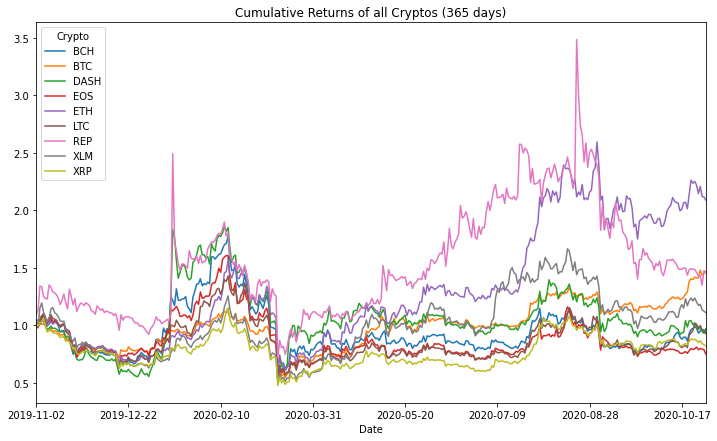

In [133]:
# Calculate cumulative returns for all cryptos

cumulative_crypto_returns.plot(figsize=(12,7), title = "Cumulative Returns of all Cryptos (365 days)")

In [134]:
# The plot shows that ETH has the highest cumulative return over the course of one year.

In [135]:
# Calculate daily std for all cryptos (365 trading days)

daily_crypto_std = daily_crypto_returns.std()
daily_crypto_std.sort_values(ascending=False)

Crypto
REP     0.093300
DASH    0.060897
BCH     0.053221
ETH     0.050333
EOS     0.049971
XLM     0.048404
LTC     0.048095
XRP     0.040593
BTC     0.038463
dtype: float64

In [136]:
# Calculate annual std for all cryptos (365 trading days)

annualized_crypto_std = daily_crypto_std * np.sqrt(365)
annualized_crypto_std.sort_values(ascending=False)

Crypto
REP     1.782489
DASH    1.163441
BCH     1.016795
ETH     0.961617
EOS     0.954687
XLM     0.924764
LTC     0.918860
XRP     0.775533
BTC     0.734836
dtype: float64

<AxesSubplot:title={'center':'Rolling 30-day Crypto Returns over 365 Days'}, xlabel='Date'>

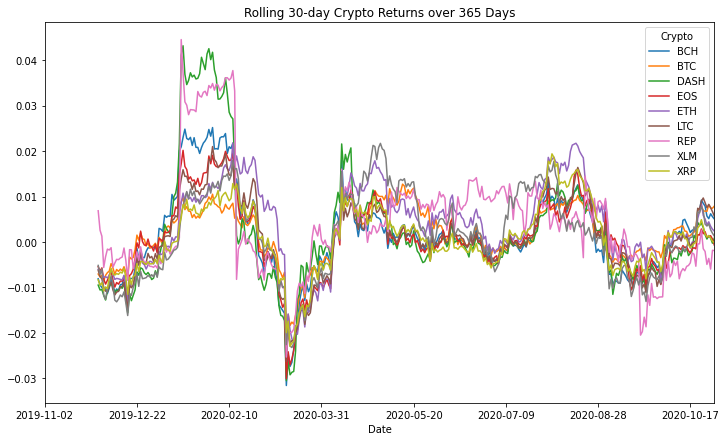

In [137]:
# Calculate rolling 30 day returns and standard deviation for all cryptos

daily_crypto_returns.rolling(window=30).mean().plot(figsize=(12,7),title="Rolling 30-day Crypto Returns over 365 Days")

<AxesSubplot:title={'center':'Rolling 30-day Crypto Standard Dev over 365 Days'}, xlabel='Date'>

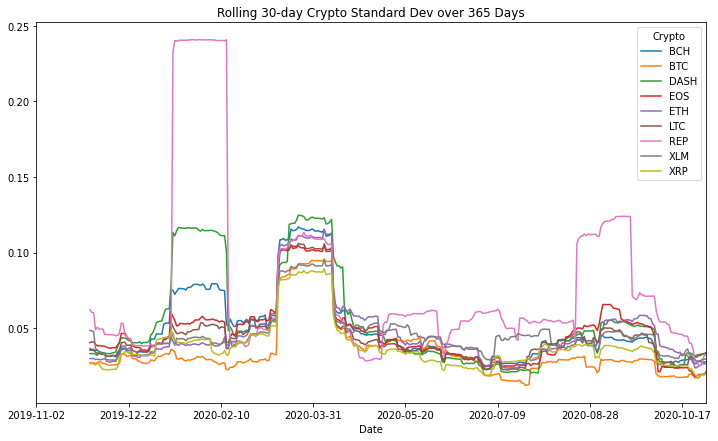

In [138]:
daily_crypto_returns.rolling(window=30).std().plot(figsize=(12,7),title="Rolling 30-day Crypto Standard Dev over 365 Days")

In [139]:
# Analysis of rolling statistics shows that REP is the most volatile of all analyzed cryptos but that excess volatility was not accompanied by higher cumulative return.

In [140]:
# Calculate return correlation between cryptos

crypto_return_corr = daily_crypto_returns.corr()
crypto_return_corr

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Crypto,,,,,,,,,
BCH,1.000000,0.850793,0.677658,0.883112,0.856685,0.899969,0.342691,0.744715,0.842874
BTC,0.850793,1.000000,0.651549,0.844700,0.875336,0.873035,0.359918,0.741244,0.827694
DASH,0.677658,0.651549,1.000000,0.673086,0.673835,0.684737,0.607577,0.610919,0.655358
EOS,0.883112,0.844700,0.673086,1.000000,0.858451,0.899345,0.362811,0.783016,0.844160
ETH,0.856685,0.875336,0.673835,0.858451,1.000000,0.897933,0.368128,0.799015,0.882235
LTC,0.899969,0.873035,0.684737,0.899345,0.897933,1.000000,0.361973,0.789825,0.870989
REP,0.342691,0.359918,0.607577,0.362811,0.368128,0.361973,1.000000,0.390933,0.355714
XLM,0.744715,0.741244,0.610919,0.783016,0.799015,0.789825,0.390933,1.000000,0.833715
XRP,0.842874,0.827694,0.655358,0.844160,0.882235,0.870989,0.355714,0.833715,1.000000


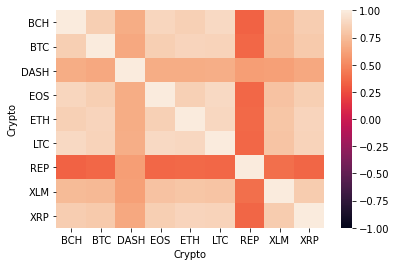

In [141]:
crypto_corr_plot = sns.heatmap(crypto_return_corr, vmin=-1, vmax =1)

In [142]:
# The least correlated cryptos are REP and BCH, the most correlated cryptos are LTC and BCH

In [143]:
sharpe_ratios = (daily_crypto_returns.mean() * 365) / annualized_crypto_std

sharpe_ratios.sort_values(ascending=False)

Crypto
ETH     1.284821
BTC     0.922631
REP     0.908800
XLM     0.587393
DASH    0.536226
BCH     0.480316
LTC     0.397668
EOS     0.206275
XRP     0.148238
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}, xlabel='Crypto'>

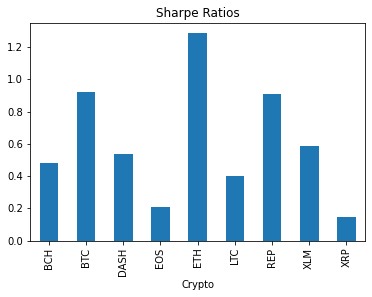

In [144]:
sharpe_ratios.plot(kind="bar",title="Sharpe Ratios")

In [145]:
# Sharpe ratio analysis shows that investing in ETH over the course of last 365 days would have achieved the highest risk adjusted return.